# Text Generation with a simple LSTM.

The goal of this notebook is to perform text generation tasks using LSTMs training on literature. I want to create next text similar to the input corpus that trains the model.

This project uses Dracula from Project Gutenberg. Unfortunately there are some spaces missing causing many unintentional compound words e.g. `latterside`, `manyimportant`, `castleoccupied`, etc.

## Inspiration and guides:
Most of the code:  
https://machinelearningmastery.com/text-generation-lstm-recurrent-neural-networks-python-keras/

Used this guys LTSM model architecture:  
https://medium.com/coinmonks/word-level-lstm-text-generator-creating-automatic-song-lyrics-with-neural-networks-b8a1617104fb

Another summary:  
https://stackabuse.com/text-generation-with-python-and-tensorflow-keras/


## Summary:

1. Read in Dracula by Bram Stoker from project Gutenberg
2. Preprocess the text to get it down to just the chapters.
3. Subselect chapters 2-4 so that the dataset is smaller to work with.
4. Remove stop words and tokenize.
5. Convert text of words into numbers.
7. Select 10 word long sentences from the corpus with the 11th word being what gets predicted.
8. Build a Bidirectional LSTM model with 128 units and dropout 0.2. Have a dense layer with a softmax activation.
9. Train the model for 40 epochs.
10. Select a random 10 word sequence as a random seed.
11. Predict the next 100 words after that sequence.

## Model structure
```
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
bidirectional (Bidirectional (None, 256)               133120    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 3476)              893332    
=================================================================
Total params: 1,026,452
Trainable params: 1,026,452
Non-trainable params: 0
_________________________________________________________________
```

## Results:

Random seed:  
`am i at your going and thatyou so suddenly desire`

Predicted next 100 words:  
`and away the awakened another sensation where the and process can boyar do of time he if the thehapsburgs know i the and and saying i to to some was was i had and the the sleep with and and to the carving makingconsignments to name is dream of i i was pride his to count and to was hungarian flood swept eastward that szekelys wereclaimed as kindred by as them to was the of and no of the i as your bushyhair that of is the the be as to the 29 june to day is the date of`

### Notes to self:
Training takes longer for more epochs and more LSTM units. Increasing the dropoff causes the loss improvement to be smaller per epoch. It is possible to overfit to the point where the next 100 words are literally those that are form the chapter. This happened with a model with 256 units and took a while to train 40 epochs.


In [1]:
import urllib
import numpy as np
import sys
import random

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Bidirectional
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint

In [2]:
url = "https://www.gutenberg.org/cache/epub/345/pg345.txt"
file = urllib.request.urlopen(url)

In [3]:
corpus = ''
for idx, line in enumerate(file):
    corpus = corpus + line.decode("utf-8")
    
print(f"Lenght of corpus: {len(corpus)}")

Lenght of corpus: 883114


In [4]:
# remove formatting and chapter lists from begining of corpus
remove_pre_formatting = corpus.split('CHAPTER I\r')[2]
# remove post formatting text after THE END.
dracula_text = remove_pre_formatting.split('THE END')[0].replace('\r',
                                            '').replace('\n', '').replace('_','').replace('*', '').replace("\'", "")

print(f"String length of Isolated Dracula Text: {len(dracula_text)}")

String length of Isolated Dracula Text: 823617


In [5]:
for idx, chapter in enumerate(dracula_text.split('CHAPTER')):
    print(f"String length of Chapter {idx+1}: {len(chapter)} ")

String length of Chapter 1: 30229 
String length of Chapter 2: 28119 
String length of Chapter 3: 29514 
String length of Chapter 4: 30167 
String length of Chapter 5: 17678 
String length of Chapter 6: 28967 
String length of Chapter 7: 30201 
String length of Chapter 8: 32436 
String length of Chapter 9: 29913 
String length of Chapter 10: 30327 
String length of Chapter 11: 26330 
String length of Chapter 12: 37267 
String length of Chapter 13: 33821 
String length of Chapter 14: 32111 
String length of Chapter 15: 29299 
String length of Chapter 16: 23550 
String length of Chapter 17: 28865 
String length of Chapter 18: 35356 
String length of Chapter 19: 29037 
String length of Chapter 20: 30681 
String length of Chapter 21: 31687 
String length of Chapter 22: 27704 
String length of Chapter 23: 29115 
String length of Chapter 24: 31751 
String length of Chapter 25: 32301 
String length of Chapter 26: 36796 
String length of Chapter 27: 40213 


In [6]:
# train on a smaller dataset to speed up time (Chapters 2-4)
dracula_text = dracula_text.split('CHAPTER')[1] + ' ' + dracula_text.split('CHAPTER')[2] + ' ' + dracula_text.split('CHAPTER')[3]
print(f"String length of abridged corpus: {len(dracula_text)}")

String length of abridged corpus: 87802


In [7]:
def tokenize_words(input):
    # lowercase everything to standardize it
    input = input.lower()

    # instantiate the tokenizer
    tokenizer = RegexpTokenizer(r"\w+|[0-9]:")
    tokens = tokenizer.tokenize(input)

    # if the created token isn't in the stop words, make it part of "filtered"
    filtered = filter(lambda token: token not in stopwords.words('english'), tokens)
    return tokens

In [8]:
output = tokenize_words(dracula_text)

In [9]:
# convert the words into numbers
words = sorted(list(set(output)))
word_to_num = dict((c, i) for i, c in enumerate(words))

# convert the numbers back into words
num_to_word = dict((i, c) for i, c in enumerate(words))

In [10]:
# summarize our dataset
n_words = len(output)
n_vocab = len(words)
print(f"Total Words in the text: {n_words}")
print(f"Total Vocabulary in the text: {n_vocab}")

Total Words in the text: 16101
Total Vocabulary in the text: 3476


In [11]:
# prepare the dataset of input to output pairs encoded as integers
seq_length = 10
dataX = []
dataY = []
for i in range(0, n_words - seq_length, 1):
    seq_in = output[i:i + seq_length]
    seq_out = output[i + seq_length]
    dataX.append([word_to_num[word] for word in seq_in])
    dataY.append(word_to_num[seq_out])
n_patterns = len(dataX)
print(f"Total Patterns: {n_patterns}")

Total Patterns: 16091


In [12]:
# reshape X to be [samples, time steps, features]
X = np.reshape(dataX, (n_patterns, seq_length, 1))

In [13]:
# normalize
X = X / float(n_vocab)

In [14]:
# one hot encode the output variable
y = np_utils.to_categorical(dataY)

In [15]:
model = Sequential()
model.add(Bidirectional(LSTM(128), input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [16]:
# define the checkpoint
filepath="weights-improvement-{epoch:02d}-{loss:.4f}-bigger.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [17]:
# This loop shows how the model slowly starts getting better with more Epochs.

for n in range(8):
    print(f"Round # {n+1}")
    # fit the model
    model.fit(X, y, epochs=10, callbacks=callbacks_list)
    
    start = np.random.randint(0, len(dataX) - 1)
    pattern = dataX[start]
    print("Random Seed:")
    print("\"", ' '.join([num_to_word[value] for value in pattern]), "\"")
    
    # Predict 100 words of text on the random seed input.
    print("100 word prediction based on seed:")
    result = "\" "
    for i in range(100):
        x = np.reshape(pattern, (1, len(pattern), 1))
        x = x / float(n_vocab)
        prediction = model.predict(x, verbose=0)
        index = np.argmax(prediction)
        result = result + num_to_word[index] + ' '

        pattern.append(index)
        pattern = pattern[1:len(pattern)]
    result = result + "\""
    print(result)
    print()
    print()

Round # 1
Epoch 1/10
503/503 [==============================] - 10s 15ms/step - loss: 6.8884

Epoch 00001: loss improved from inf to 6.68126, saving model to weights-improvement-01-6.6813-bigger.hdf5
Epoch 2/10
503/503 [==============================] - 7s 15ms/step - loss: 6.3514

Epoch 00002: loss improved from 6.68126 to 6.38791, saving model to weights-improvement-02-6.3879-bigger.hdf5
Epoch 3/10
503/503 [==============================] - 7s 15ms/step - loss: 6.3596

Epoch 00003: loss improved from 6.38791 to 6.35979, saving model to weights-improvement-03-6.3598-bigger.hdf5
Epoch 4/10
503/503 [==============================] - 7s 15ms/step - loss: 6.3175

Epoch 00004: loss improved from 6.35979 to 6.34626, saving model to weights-improvement-04-6.3463-bigger.hdf5
Epoch 5/10
503/503 [==============================] - 7s 14ms/step - loss: 6.3243

Epoch 00005: loss improved from 6.34626 to 6.34241, saving model to weights-improvement-05-6.3424-bigger.hdf5
Epoch 6/10
503/503 [========

Epoch 5/10
503/503 [==============================] - 8s 15ms/step - loss: 3.1170

Epoch 00005: loss improved from 3.20373 to 3.11697, saving model to weights-improvement-05-3.1170-bigger.hdf5
Epoch 6/10
503/503 [==============================] - 7s 15ms/step - loss: 3.0431

Epoch 00006: loss improved from 3.11697 to 3.04312, saving model to weights-improvement-06-3.0431-bigger.hdf5
Epoch 7/10
503/503 [==============================] - 8s 15ms/step - loss: 2.9507

Epoch 00007: loss improved from 3.04312 to 2.95066, saving model to weights-improvement-07-2.9507-bigger.hdf5
Epoch 8/10
503/503 [==============================] - 7s 15ms/step - loss: 2.8841

Epoch 00008: loss improved from 2.95066 to 2.88406, saving model to weights-improvement-08-2.8841-bigger.hdf5
Epoch 9/10
503/503 [==============================] - 8s 15ms/step - loss: 2.8067

Epoch 00009: loss improved from 2.88406 to 2.80669, saving model to weights-improvement-09-2.8067-bigger.hdf5
Epoch 10/10
503/503 [==============

503/503 [==============================] - 7s 14ms/step - loss: 1.5013

Epoch 00008: loss improved from 1.53401 to 1.50134, saving model to weights-improvement-08-1.5013-bigger.hdf5
Epoch 9/10
503/503 [==============================] - 8s 16ms/step - loss: 1.4591

Epoch 00009: loss improved from 1.50134 to 1.45910, saving model to weights-improvement-09-1.4591-bigger.hdf5
Epoch 10/10
503/503 [==============================] - 8s 16ms/step - loss: 1.4398

Epoch 00010: loss improved from 1.45910 to 1.43983, saving model to weights-improvement-10-1.4398-bigger.hdf5
Random Seed:
" the castle it is old and hasmany memories and there "
100 word prediction based on seed:
" the i i of did that of he face i the isthat and glad all of find the away of whispered which two started dark from stay the the and and though the and stillness were roughly is great when the count the the and bound volumes a is neck i with back i through shaving to it and the it the it and the the i the forgive the who be 

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 256)               133120    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 3476)              893332    
Total params: 1,026,452
Trainable params: 1,026,452
Non-trainable params: 0
_________________________________________________________________


# LSTM model Visualized

In [19]:
from keras.utils.vis_utils import plot_model

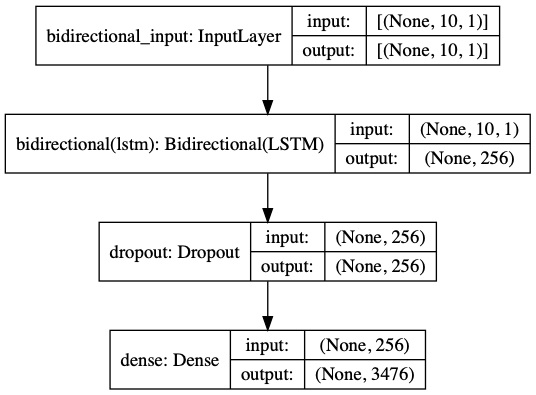

In [20]:
plot_model(model, show_shapes=True, show_layer_names=True)